### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
# sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSBSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12791
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    938.8| 32.1794|-110.7364|       TMAX|USC00027398|    10|[B0 58 10 5A 40 5...|2010.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMAX|USC00027398|    16|[00 53 80 54 08 5...|2011.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMAX|USC00027398|    32|[A0 5B D0 5B 48 5...|2012.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMIN|USC00027398|    16|[00 4F 80 51 00 5...|2010.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMIN|USC00027398|    19|[40 D2 40 D2 40 D...|2011.0|SSSSBSSB|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
df.show(100)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    938.8| 32.1794|-110.7364|       TMAX|USC00027398|    10|[B0 58 10 5A 40 5...|2010.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMAX|USC00027398|    16|[00 53 80 54 08 5...|2011.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMAX|USC00027398|    32|[A0 5B D0 5B 48 5...|2012.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMIN|USC00027398|    16|[00 4F 80 51 00 5...|2010.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMIN|USC00027398|    19|[40 D2 40 D2 40 D...|2011.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TMIN|USC00027398|    33|[90 55 E0 55 E0 5...|2012.0|SSSSBSSB|
|    938.8| 32.1794|-110.7364|       TOBS|USC00027398|    10|[80 54 90 55 90 5...|2010.0|SSSSBSSB|
|    938.8

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [26]:
def plot_pair(pair,func, scale=1.0):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)

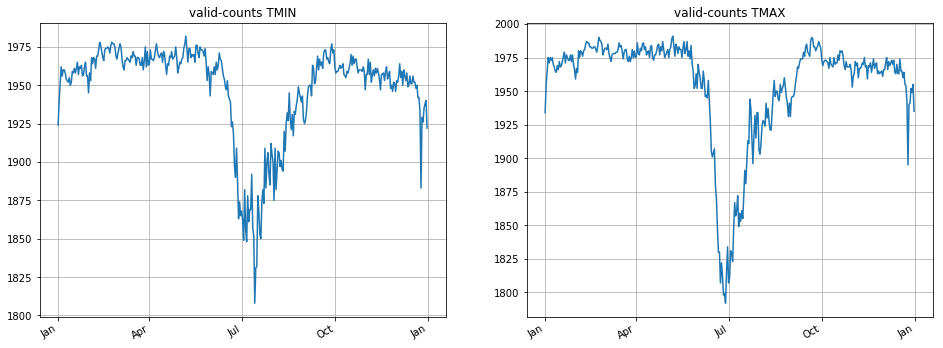

In [20]:
plot_pair(['TMIN','TMAX'],plot_valid)

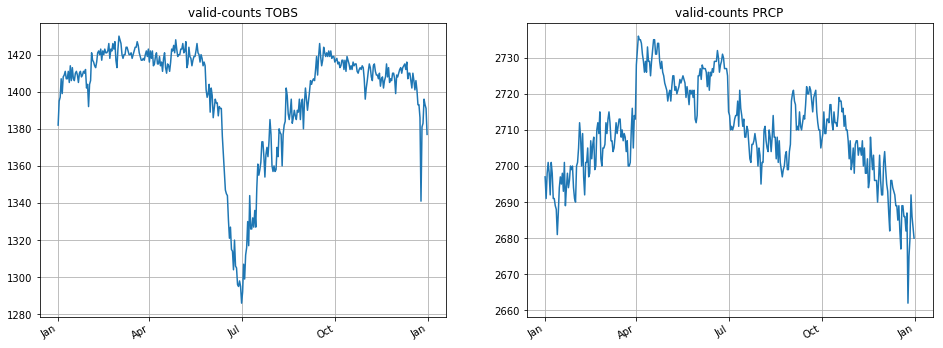

In [21]:
plot_pair(['TOBS','PRCP'],plot_valid)

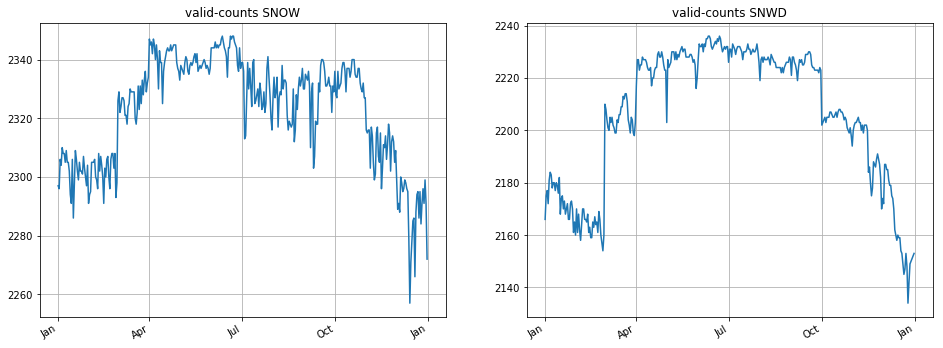

In [22]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [31]:
def plot_pair(pair,func, scale=1.0):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis, scale)
def plot_mean_std(m,fig,axis, scale=1.0):
    mean=STAT[m]['Mean'] / scale
    std=np.sqrt(STAT[m]['Var']) / scale
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m, labels = ["mean-std", "mean", "mean+std"])

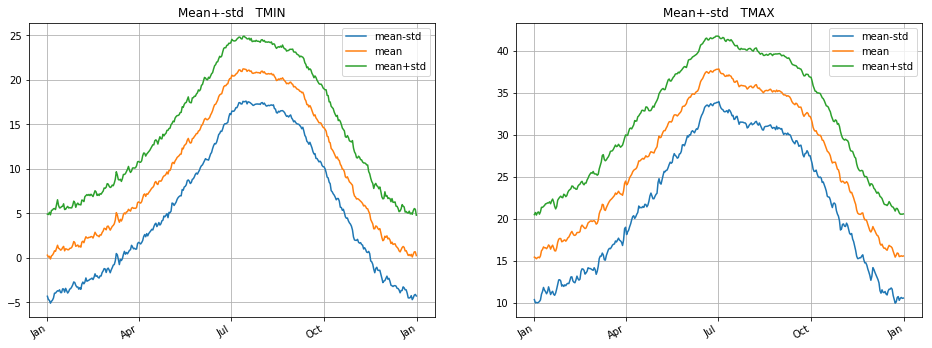

In [32]:
plot_pair(['TMIN','TMAX'],plot_mean_std, 10)

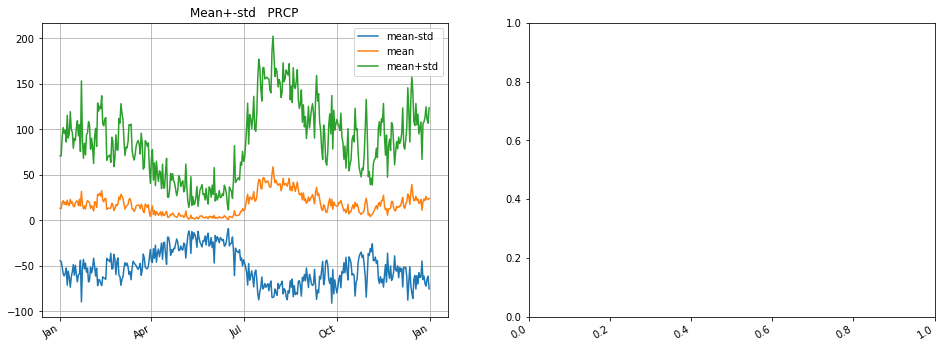

In [36]:
plot_pair(['PRCP'],plot_mean_std, 0.5)

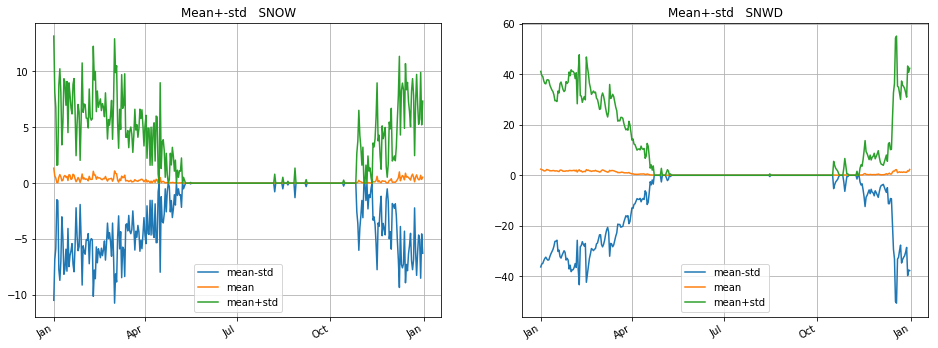

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [13]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m, labels=["first", "second", "third"])

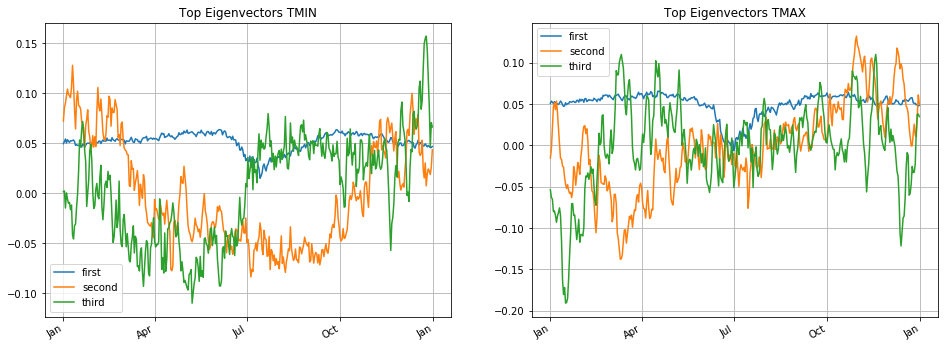

In [14]:
plot_pair(['TMIN','TMAX'],plot_eigen)

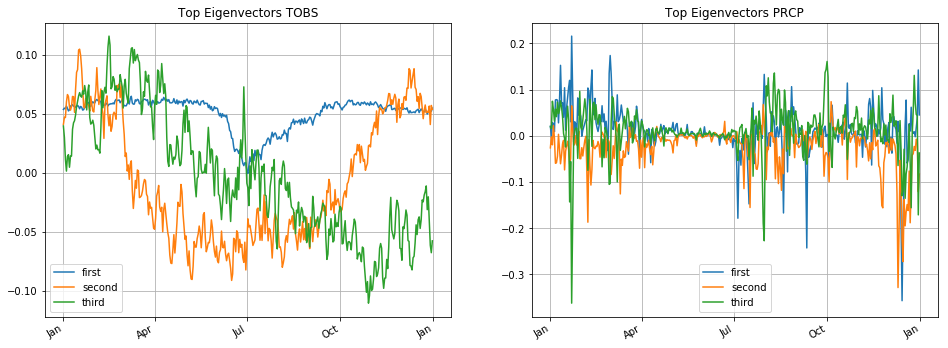

In [15]:
plot_pair(['TOBS','PRCP'],plot_eigen)

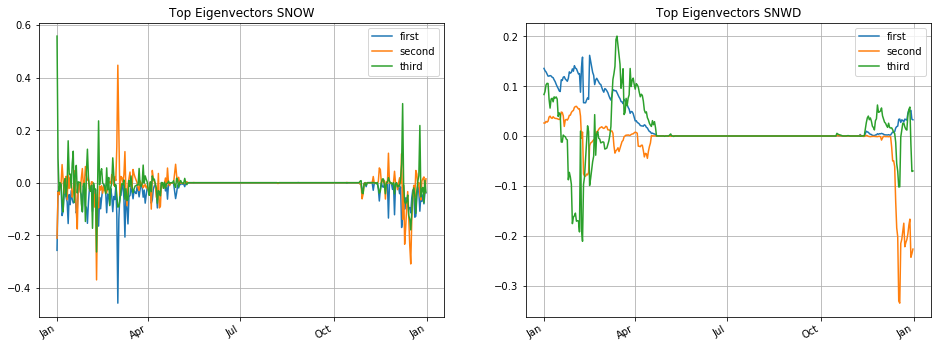

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [17]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

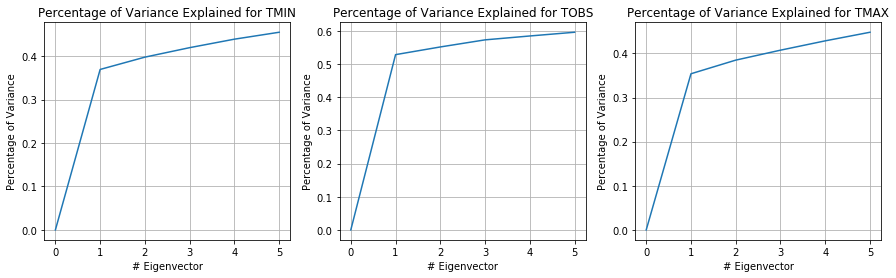

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

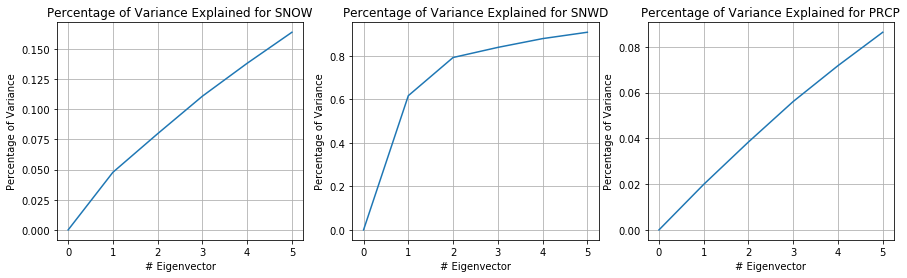

In [19]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [20]:
sc.stop()